# Used Cars Price Predictor

This project is focused on building a machine learning model to predict the prices of used cars. The dataset was scraped from a popular online platform for car listings in Poland.

# Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import joblib

from matplotlib.ticker import MaxNLocator
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import probplot
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold, LearningCurveDisplay

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [2]:
directory = 'data'
car_list = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
car_list

['audi.csv',
 'bmw.csv',
 'chevrolet.csv',
 'citroen.csv',
 'dacia.csv',
 'dodge.csv',
 'fiat.csv',
 'ford.csv',
 'honda.csv',
 'hyundai.csv',
 'jeep.csv',
 'kia.csv',
 'land-rover.csv',
 'lexus.csv',
 'mazda.csv',
 'mercedes-benz.csv',
 'mitsubishi.csv',
 'nissan.csv',
 'opel.csv',
 'peugeot.csv',
 'renault.csv',
 'seat.csv',
 'skoda.csv',
 'suzuki.csv',
 'toyota.csv',
 'volkswagen.csv',
 'volvo.csv']

In [3]:
dfs = [pd.read_csv(os.path.join(directory, car)) for car in car_list]
df = pd.concat(dfs, ignore_index=True)

# Exploratory Data Analysis, Data Cleaning and Feature Engineering

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24544 entries, 0 to 24543
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Marka              24513 non-null  object 
 1   Model              24513 non-null  object 
 2   Rok produkcji      24544 non-null  object 
 3   Cena               24544 non-null  object 
 4   Przebieg           24513 non-null  object 
 5   Rodzaj paliwa      24513 non-null  object 
 6   Skrzynia biegów    24511 non-null  object 
 7   Typ nadwozia       24513 non-null  object 
 8   Pojemność skokowa  24256 non-null  object 
 9   Moc                24489 non-null  object 
 10  Liczba drzwi       24428 non-null  float64
 11  Kolor              24470 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.2+ MB


**Marka** - Brand

**Model** - Car model

**Rok produkcji** - Year of Production

**Cena** - Price

**Przebieg** - Mileage

**Rodzaj paliwa** - Fuel Type

**Skrzynia biegów** - Transmission 

**Typ nadwozia** - Body

**Pojemność skokowa** - Engine Capacity

**Moc** - Power

**Liczba drzwi** - Number of Doors

**Kolor** - Color

For better understanding, I'll convert the feature names to their English equivalents.

In [5]:
df.rename(columns={
    'Marka': 'brand',
    'Model': 'car_model',
    'Rok produkcji': 'year_of_production',
    'Cena': 'price',
    'Przebieg': 'mileage',
    'Rodzaj paliwa': 'fuel_type',
    'Skrzynia biegów': 'transmission',
    'Typ nadwozia': 'body',
    'Pojemność skokowa': 'engine_capacity',
    'Moc': 'power',
    'Liczba drzwi': 'number_of_doors',
    'Kolor': 'color'
}, inplace=True)

In [6]:
df.head()

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
0,Audi,Q8,2018,267 000 PLN,196 335 km,Diesel,Automatyczna,SUV,2 967 cm3,286 KM,5.0,Granatowy
1,Audi,A7,2021,198 999,93 000 km,Hybryda Plug-in,Automatyczna,Coupe,1 984 cm3,265 KM,5.0,Czerwony
2,Audi,RS7,2024,798 600 PLN,5 km,Benzyna,Automatyczna,Kompakt,3 996 cm3,630 KM,5.0,Czarny
3,Audi,Q3,2024,191 900 PLN,1 km,Benzyna,Manualna,Kompakt,1 498 cm3,150 KM,5.0,Czerwony
4,Audi,Q5,2024,234 900 PLN,1 km,Diesel,Automatyczna,SUV,1 968 cm3,204 KM,5.0,Niebieski


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24544 entries, 0 to 24543
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               24513 non-null  object 
 1   car_model           24513 non-null  object 
 2   year_of_production  24544 non-null  object 
 3   price               24544 non-null  object 
 4   mileage             24513 non-null  object 
 5   fuel_type           24513 non-null  object 
 6   transmission        24511 non-null  object 
 7   body                24513 non-null  object 
 8   engine_capacity     24256 non-null  object 
 9   power               24489 non-null  object 
 10  number_of_doors     24428 non-null  float64
 11  color               24470 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.2+ MB


In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
engine_capacity,288,0.011734
number_of_doors,116,0.004726
color,74,0.003015
power,55,0.002241
transmission,33,0.001345
body,31,0.001263
car_model,31,0.001263
brand,31,0.001263
mileage,31,0.001263
fuel_type,31,0.001263


First of all, we need to handle data that is clearly irrelevant. In our dataset, any entries where the *year_of_production* feature is marked as 'Unknown' are instances where the web scraper captured incorrect information. These rows provide no value , so we need to identify and remove them.

In [9]:
df[df['year_of_production']=='Unknown'].head(3)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
894,NaN,NaN,Unknown,nowe i używane samochody i motocykle oraz częś...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1796,NaN,NaN,Unknown,nowe i używane samochody i motocykle oraz częś...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,NaN,NaN,Unknown,nowe i używane samochody i motocykle oraz częś...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
len(df[df['year_of_production']=='Unknown'])

31

There is not a lot of such data, easy to identify and remove.

In [11]:
df = df[df['year_of_production'] != 'Unknown']
len(df[df['year_of_production']=='Unknown'])

0

Now let's check how our missing_data table has changed.

In [12]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
engine_capacity,257,0.010484
number_of_doors,85,0.003468
color,43,0.001754
power,24,0.000979
transmission,2,0.000082
year_of_production,0,0.000000
car_model,0,0.000000
brand,0,0.000000
price,0,0.000000
body,0,0.000000


Since the missing data represents less than 1% of the entire dataset, we don't need to focus on imputing it. Instead, we can safely remove all rows with missing data without any significant impact on our analysis.

In [13]:
df.dropna(inplace=True)

Let's make sure if we removed it all

In [14]:
df.isna().sum().max()

np.int64(0)

Great, we handled all the missing data.

In [15]:
dtype_table = pd.DataFrame(df.dtypes, columns=['Dtype'])
dtype_table

,Dtype
brand,object
car_model,object
year_of_production,object
price,object
mileage,object
fuel_type,object
transmission,object
body,object
engine_capacity,object
power,object


**Categorical features**:

Nominal: brand, car_model, fuel_type, transmission, body, color

Ordinal: None

**Numerical features**:

Discrete: year_of_production, number_of_doors

Continuous: price, mileage, engine_capacity, power

In [16]:
df.head()

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
0,Audi,Q8,2018,267 000 PLN,196 335 km,Diesel,Automatyczna,SUV,2 967 cm3,286 KM,5.0,Granatowy
1,Audi,A7,2021,198 999,93 000 km,Hybryda Plug-in,Automatyczna,Coupe,1 984 cm3,265 KM,5.0,Czerwony
2,Audi,RS7,2024,798 600 PLN,5 km,Benzyna,Automatyczna,Kompakt,3 996 cm3,630 KM,5.0,Czarny
3,Audi,Q3,2024,191 900 PLN,1 km,Benzyna,Manualna,Kompakt,1 498 cm3,150 KM,5.0,Czerwony
4,Audi,Q5,2024,234 900 PLN,1 km,Diesel,Automatyczna,SUV,1 968 cm3,204 KM,5.0,Niebieski


We can observe that the columns intended to be numerical have incorrect data types and include unnecessary text, such as 'PLN' in the *price* column or 'km' in the *mileage* column. Therefore, we need to clean the data by removing these extraneous characters and updating the data types accordingly.

In [17]:
df['year_of_production'] = pd.to_numeric(df['year_of_production'], errors='raise')
df['price'] = (
    df['price']
    .str.replace(r'[^\d.]', '', regex=True)
    .astype(float)
)
df['mileage'] = (
    df['mileage']
    .str.replace(r'\D', '', regex=True)
    .astype(int)
)
df['engine_capacity'] = (
    df['engine_capacity']
    .str.replace('cm3', '', regex=False)
    .str.replace(' ', '')
    .astype(float) / 1000
)
df['power'] = (
    df['power']
    .str.replace(r'[^\d.]', '', regex=True)
    .astype(float)
)
df['number_of_doors'] = df['number_of_doors'].astype(int)

All done!

In [18]:
dtype_table = pd.DataFrame(df.dtypes, columns=['Dtype'])
dtype_table

,Dtype
brand,object
car_model,object
year_of_production,int64
price,float64
mileage,int64
fuel_type,object
transmission,object
body,object
engine_capacity,float64
power,float64


In [19]:
df.head()

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
0,Audi,Q8,2018,267000.0,196335,Diesel,Automatyczna,SUV,2.967,286.0,5,Granatowy
1,Audi,A7,2021,198999.0,93000,Hybryda Plug-in,Automatyczna,Coupe,1.984,265.0,5,Czerwony
2,Audi,RS7,2024,798600.0,5,Benzyna,Automatyczna,Kompakt,3.996,630.0,5,Czarny
3,Audi,Q3,2024,191900.0,1,Benzyna,Manualna,Kompakt,1.498,150.0,5,Czerwony
4,Audi,Q5,2024,234900.0,1,Diesel,Automatyczna,SUV,1.968,204.0,5,Niebieski


Looks cleaner already!

In [20]:
unique_values = {
    'fuel_type': df['fuel_type'].unique().tolist(),
    'transmission': df['transmission'].unique().tolist(),
    'body': df['body'].unique().tolist(),
    'color': df['color'].unique().tolist(),
}

for feature, values in unique_values.items():
    print(f"{feature}: {values}")

fuel_type: ['Diesel', 'Hybryda Plug-in', 'Benzyna', 'Hybryda', 'Benzyna+LPG', 'Benzyna+CNG']
transmission: ['Automatyczna', 'Manualna']
body: ['SUV', 'Coupe', 'Kompakt', 'Kombi', 'Auta miejskie', 'Sedan', 'Auta małe', 'Kabriolet', 'Minivan']
color: ['Granatowy', 'Czerwony', 'Czarny', 'Niebieski', 'Bordowy', 'Biały', 'Szary', 'Błękitny', 'Srebrny', 'Inny kolor', 'Złoty', 'Żółty', 'Brązowy', 'Zielony', 'Beżowy', 'Pomarańczowy', 'Fioletowy']


Let's replace the values in the fuel_type, transmission, body, and color columns with their English equivalents.

In [21]:
fuel_map = {
    'Diesel': 'Diesel',
    'Hybryda Plug-in': 'Plug-in Hybrid',
    'Benzyna': 'Petrol',
    'Hybryda': 'Hybrid',
    'Benzyna+LPG': 'Petrol+LPG',
    'Benzyna+CNG': 'Petrol+CNG'
}

transmission_map = {
    'Automatyczna': 'Automatic',
    'Manualna': 'Manual'
}

body_map = {
    'SUV': 'SUV',
    'Coupe': 'Coupe',
    'Kompakt': 'Compact',
    'Kombi': 'Wagon',
    'Auta miejskie': 'City Car',
    'Sedan': 'Sedan',
    'Auta małe': 'Small Car',
    'Kabriolet': 'Convertible',
    'Minivan': 'Minivan'
}

color_map = {
    'Granatowy': 'Navy Blue',
    'Czerwony': 'Red',
    'Czarny': 'Black',
    'Niebieski': 'Blue',
    'Bordowy': 'Burgundy',
    'Biały': 'White',
    'Szary': 'Gray',
    'Błękitny': 'Light Blue',
    'Srebrny': 'Silver',
    'Inny kolor': 'Other',
    'Złoty': 'Gold',
    'Żółty': 'Yellow',
    'Brązowy': 'Brown',
    'Zielony': 'Green',
    'Beżowy': 'Beige',
    'Pomarańczowy': 'Orange',
    'Fioletowy': 'Purple'
}

df['fuel_type'] = df['fuel_type'].map(fuel_map)
df['transmission'] = df['transmission'].map(transmission_map)
df['body'] = df['body'].map(body_map)
df['color'] = df['color'].map(color_map)

In [22]:
unique_values = {
    'fuel_type': df['fuel_type'].unique().tolist(),
    'transmission': df['transmission'].unique().tolist(),
    'body': df['body'].unique().tolist(),
    'color': df['color'].unique().tolist(),
}

for feature, values in unique_values.items():
    print(f"{feature}: {values}")

fuel_type: ['Diesel', 'Plug-in Hybrid', 'Petrol', 'Hybrid', 'Petrol+LPG', 'Petrol+CNG']
transmission: ['Automatic', 'Manual']
body: ['SUV', 'Coupe', 'Compact', 'Wagon', 'City Car', 'Sedan', 'Small Car', 'Convertible', 'Minivan']
color: ['Navy Blue', 'Red', 'Black', 'Blue', 'Burgundy', 'White', 'Gray', 'Light Blue', 'Silver', 'Other', 'Gold', 'Yellow', 'Brown', 'Green', 'Beige', 'Orange', 'Purple']


In [23]:
unique_values = df.nunique().sort_values(ascending=False)
unique_data = pd.DataFrame(unique_values, columns=['Unique values'])
unique_data

,Unique values
mileage,8533
price,3522
car_model,636
engine_capacity,484
power,415
year_of_production,66
brand,27
color,17
body,9
fuel_type,6


In [24]:
df['car_model'].value_counts()

car_model
Qashqai       406
Leon          377
Duster        342
Civic         332
Octavia       319
             ... 
Expedition      1
R8              1
S4              1
945             1
850             1
Name: count, Length: 636, dtype: int64

We can notice here, what cars are the most popular.

In [25]:
df['car_model'].value_counts()[df['car_model'].value_counts() < 10]

car_model
Taigo              9
SpaceTourer        9
Transit Connect    9
Pajero Pinin       9
Adam               9
                  ..
Expedition         1
R8                 1
S4                 1
945                1
850                1
Name: count, Length: 303, dtype: int64

In [26]:
df['car_model'].value_counts()[df['car_model'].value_counts() < 10].sum()

np.int64(1040)

One feature worth taking a closer look at is *car_model*. We observe that many values appear very infrequently. It might be a good idea to remove these rare occurrences, as their small sample size would provide insufficient data for the model to learn effectively. These models are also not commonly seen, making them less relevant for prediction. Therefore, let's remove the rows where the value count of *car_model* is less than 10. We may also want to apply this approach to other features in case there are additional rare occurrences.

Furthermore, the *car_model* feature includes a value labeled Inny (meaning "Other"), which is not relevant for our analysis, so we will drop this value as well.

In [27]:
cat_features = df.select_dtypes(include=['object']).columns
for column in cat_features:
    df = df.groupby(column).filter(lambda x: len(x) >= 10)
    
df = df[df['car_model'] != 'Inny']    

Here we go!

In [28]:
df.describe()

,year_of_production,price,mileage,engine_capacity,power,number_of_doors
count,23116.000000,2.311600e+04,2.311600e+04,23116.000000,23116.000000,23116.000000
mean,2015.221319,7.848198e+04,1.381155e+05,1.981576,164.745198,4.733907
std,5.961364,8.978228e+04,9.326812e+04,0.966738,85.498297,0.666762
min,1900.000000,4.000000e+02,1.000000e+00,0.600000,1.000000,2.000000
25%,2011.000000,2.690000e+04,6.588575e+04,1.461000,110.000000,5.000000
50%,2016.000000,5.200000e+04,1.379270e+05,1.798000,141.000000,5.000000
75%,2019.000000,9.550000e+04,1.990000e+05,1.998000,185.000000,5.000000
max,2024.000000,1.599000e+06,2.344418e+06,8.000000,843.000000,6.000000


In [29]:
cat_features = ['fuel_type', 'transmission', 'body', 'color']
num_features = df.select_dtypes(include=['int', 'float']).columns.tolist()

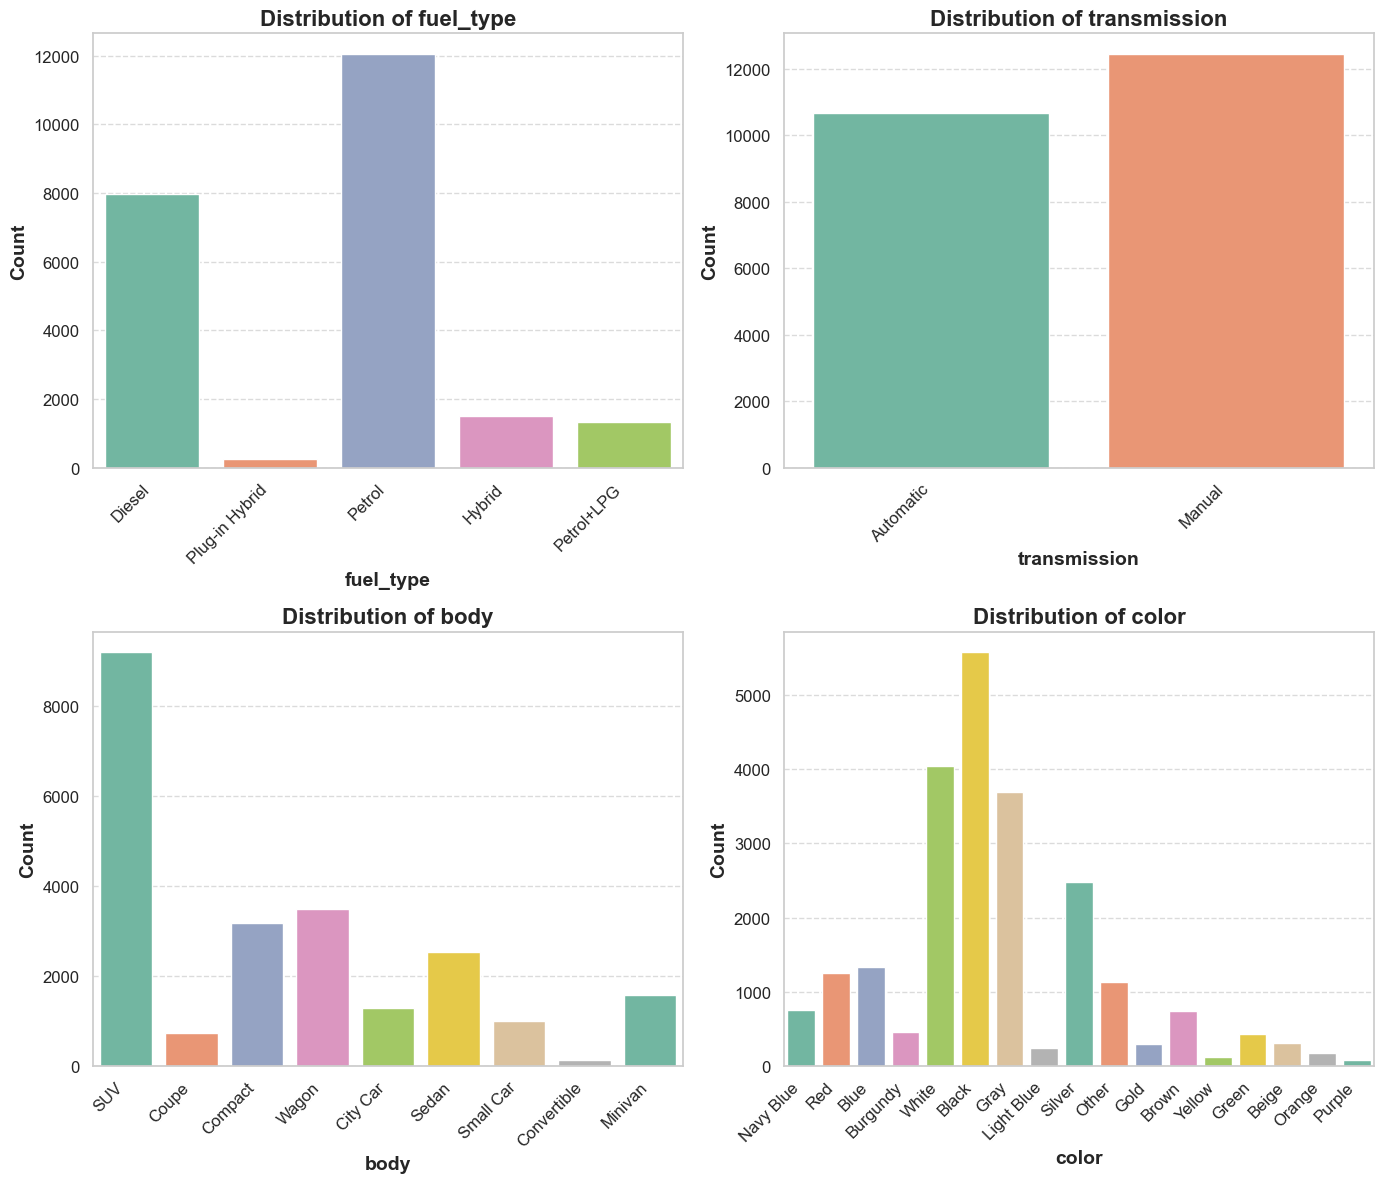

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
ax = ax.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(data=df, x=col, ax=ax[i], palette='Set2')
    ax[i].set_xlabel(col, fontsize=14, fontweight='bold')
    ax[i].set_ylabel('Count', fontsize=14, fontweight='bold')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].set_title(f'Distribution of {col}', fontsize=16, fontweight='bold')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
    ax[i].grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

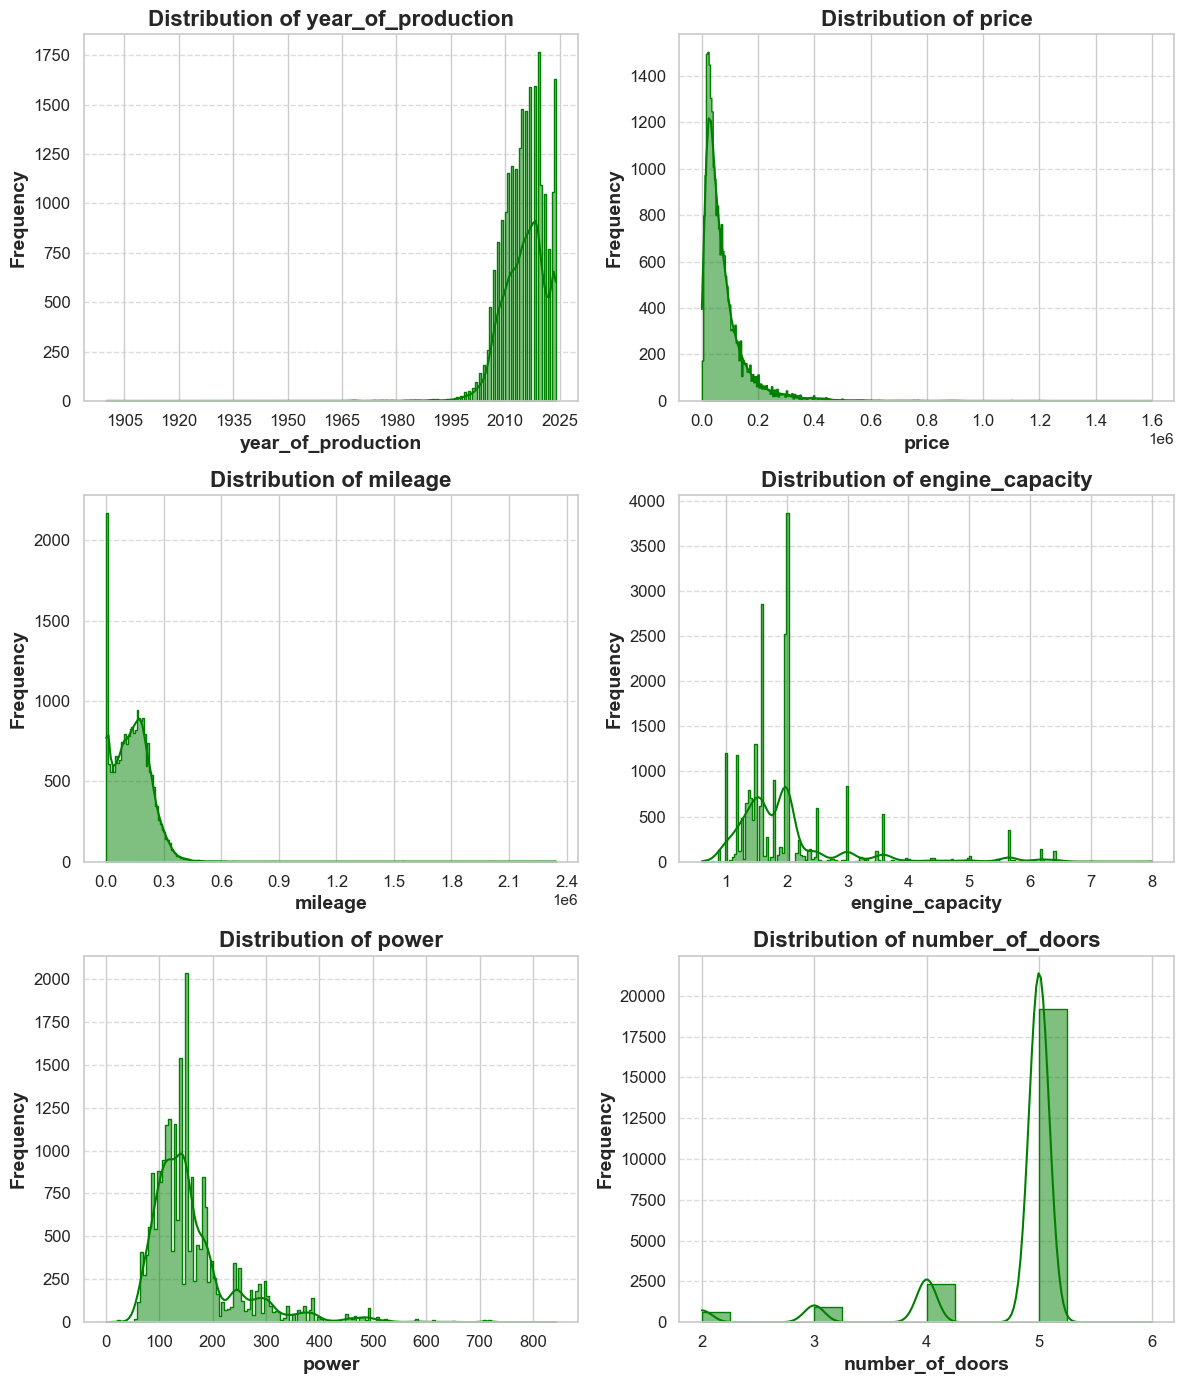

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(12, 14))
ax = ax.flatten()

for i, col in enumerate(num_features):
    sns.histplot(data=df, x=col, ax=ax[i], color='green', element='step', kde=True)
    ax[i].set_xlabel(col, fontsize=14, fontweight='bold')
    ax[i].set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].set_title(f'Distribution of {col}', fontsize=16, fontweight='bold')
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

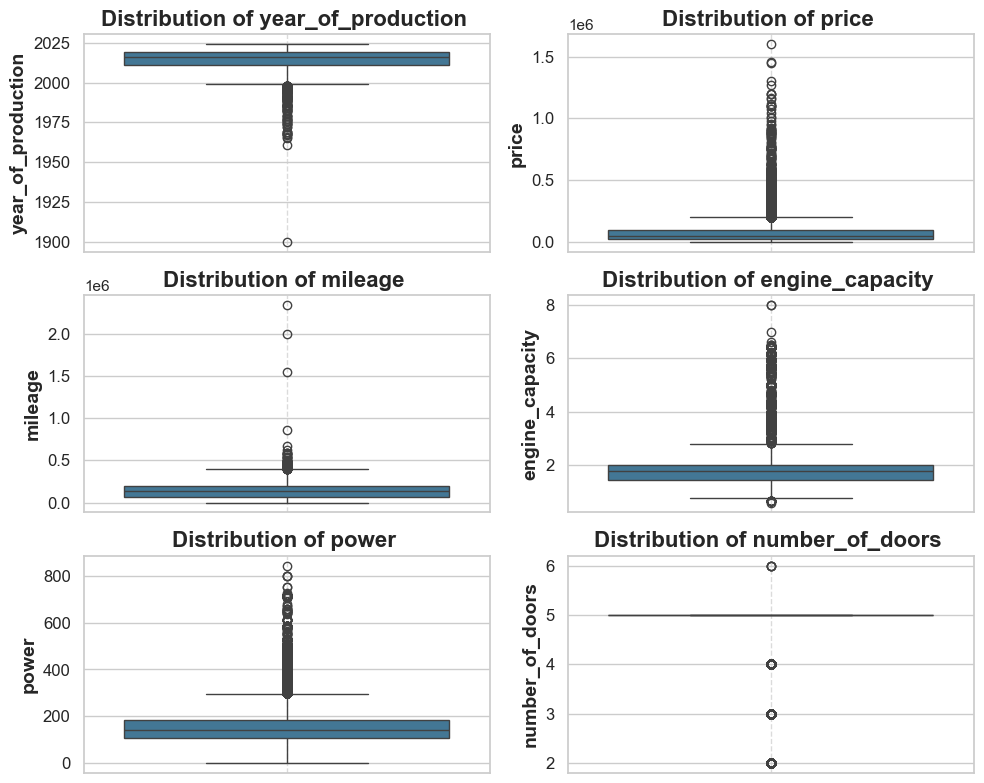

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
ax = ax.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(data=df, y=col, ax=ax[i], palette='mako')
    ax[i].set_xlabel('')
    ax[i].set_ylabel(col, fontsize=14, fontweight='bold')
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].set_title(f'Distribution of {col} ', fontsize=16, fontweight='bold')
    ax[i].grid(True, which='major', axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

On the boxplots, we observe a significant number of outliers across all features.

**Number of Doors:**

The distribution of the *number_of_doors* is relatively concentrated, with no significant outliers. This is expected, as most cars typically have either 3 or 5 doors, although other values are also common.

**Year of Production:**

In [33]:
df.sort_values(by='year_of_production', ascending=True).head(5)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
5910,Fiat,600,1900,94999.0,5,Petrol,Automatic,Compact,1.200,100.0,5,Red
1955,Chevrolet,Corvette,1961,719000.0,67425,Petrol,Manual,Convertible,4.638,220.0,2,Red
5822,Fiat,600,1965,67000.0,69196,Petrol,Manual,Small Car,0.767,31.0,2,White
5803,Fiat,600,1966,38000.0,17161,Petrol,Manual,Small Car,0.767,32.0,2,Beige
6069,Fiat,500,1967,77900.0,99,Petrol,Manual,Small Car,0.600,23.0,2,Blue


In terms of *year_of_production*, there is an obvious outlier that, upon inspection, was determined to be incorrect. The other values appear to be genuine, as they simply represent older vehicles.

In [34]:
df = df.drop(df['year_of_production'].nsmallest(1).index)

**Price:**

In [35]:
df.sort_values(by='price', ascending=False).head(10)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
13711,Mercedes-Benz,Klasa G,2022,1599000.0,10,Petrol,Automatic,SUV,3.982,585.0,5,Blue
11017,Land,Rover Range Rover,2024,1459000.0,5000,Petrol,Automatic,SUV,4.395,615.0,5,Blue
13584,Mercedes-Benz,Klasa G,2023,1449999.0,5,Petrol,Automatic,SUV,3.982,585.0,5,Blue
13558,Mercedes-Benz,Klasa G,2024,1299000.0,10,Petrol,Automatic,SUV,3.982,585.0,5,Black
13833,Mercedes-Benz,Klasa S,2024,1269000.0,5,Petrol,Automatic,Sedan,5.980,612.0,4,Red
11571,Land,Rover Range Rover,2023,1200000.0,21000,Petrol,Automatic,SUV,4.395,530.0,5,Brown
13902,Mercedes-Benz,Klasa S,2023,1199999.0,5,Petrol,Automatic,Sedan,5.980,612.0,4,Green
10986,Land,Rover Range Rover,2023,1194900.0,10,Diesel,Automatic,SUV,2.998,350.0,5,Black
13838,Mercedes-Benz,Klasa S,2024,1167550.0,1,Hybrid,Automatic,Sedan,3.982,503.0,4,Black
11100,Land,Rover Range Rover Sport,2024,1154320.0,10,Petrol,Automatic,SUV,4.395,635.0,5,Silver


In [36]:
df.sort_values(by='price', ascending=False).tail(5)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
22778,Volkswagen,Passat,1999,1700.0,294000,Petrol,Manual,Sedan,1.781,125.0,4,Green
5951,Fiat,Punto,2004,1400.0,110000,Petrol,Manual,City Car,1.242,60.0,5,Gray
2516,Chevrolet,Kalos,2005,1300.0,250000,Petrol,Manual,Small Car,1.150,72.0,3,Silver
2028,Chevrolet,Orlando,2012,400.0,240000,Diesel,Manual,Minivan,1.998,130.0,5,Gray
8351,Hyundai,ix35,2014,400.0,299000,Diesel,Manual,SUV,1.685,115.0,5,Gray


The *price* feature appears to be in good condition, as the prices seem realistic. The extremely high prices correspond to the newest models of the best cars.

**Engine Capacity:**

In [37]:
df.sort_values(by='engine_capacity', ascending=False).head(5)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
4969,Dodge,RAM,2005,129000.0,99000,Petrol,Automatic,SUV,8.000,500.0,2,Black
5074,Dodge,RAM,1999,65000.0,161700,Petrol,Automatic,SUV,7.994,305.0,4,Black
2419,Chevrolet,Corvette,1968,179999.0,68651,Petrol,Automatic,Convertible,6.996,390.0,2,Red
2136,Chevrolet,Silverado,2022,189000.0,57773,Diesel,Automatic,SUV,6.600,445.0,4,Black
2004,Chevrolet,Camaro,1968,269000.0,60000,Petrol,Manual,Coupe,6.500,400.0,2,Blue


The distribution of *engine_capacity* shows a few outliers on both the higher and lower ends. I decided to remove the two highest values because they significantly deviate from the typical range of engine capacities found in the dataset. 

In [38]:
df = df.drop(df['engine_capacity'].nlargest(2).index)

**Mileage:**

In [39]:
df.sort_values(by='mileage', ascending=False).head(10)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
21969,Toyota,Corolla,2007,16605.0,2344418,Diesel,Manual,Sedan,1.364,90.0,4,Light Blue
23857,Volvo,V50,2008,14200.0,2005364,Diesel,Manual,Wagon,1.560,109.0,5,Black
1332,BMW,Seria 3,2009,23800.0,1543465,Petrol,Manual,Sedan,1.995,143.0,4,Black
16200,Opel,Vivaro,2015,39900.0,860200,Diesel,Manual,Minivan,1.598,120.0,5,Black
22585,Toyota,Corolla,2019,50900.0,672150,Hybrid,Automatic,Wagon,1.798,98.0,5,Silver
5965,Fiat,Ducato,2005,8610.0,620000,Diesel,Manual,SUV,2.800,128.0,4,White
22774,Volkswagen,Passat,2003,3000.0,593000,Diesel,Manual,Sedan,1.896,130.0,5,Navy Blue
4955,Dodge,Grand Caravan,2018,56000.0,591538,Petrol,Automatic,Minivan,3.605,283.0,5,Silver
4648,Dodge,RAM,2020,200000.0,590000,Petrol,Automatic,SUV,5.654,390.0,4,Navy Blue
1214,BMW,Seria 7,2011,44900.0,575556,Diesel,Automatic,Sedan,2.993,245.0,4,Black


The distribution of *mileage* shows a few outliers on the higher end. In this instance, I chose to remove the four highest outliers for the same reason as stated for *engine_capacity* - to prevent skewing the analysis due to values that significantly deviate from the typical range.

In [40]:
df = df.drop(df['mileage'].nlargest(4).index)

**Power**:

In [41]:
df.sort_values(by='power', ascending=True).head(5)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
4586,Dodge,Grand Caravan,2020,69900.0,160000,Petrol,Automatic,Minivan,3.605,1.0,5,Gray
5486,Fiat,126,1986,13000.0,60102,Petrol,Manual,Small Car,0.650,15.0,2,Blue
5538,Fiat,126,1979,9900.0,29800,Petrol,Manual,Small Car,0.652,23.0,2,Other
5869,Fiat,126,1991,18500.0,48800,Petrol,Manual,Compact,0.652,23.0,2,Red
6069,Fiat,500,1967,77900.0,99,Petrol,Manual,Small Car,0.600,23.0,2,Blue


In [42]:
df.sort_values(by='power', ascending=False).head(5)

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
13806,Mercedes-Benz,AMG GT,2023,1044953.0,3001,Plug-in Hybrid,Automatic,Coupe,3.982,843.0,5,Gray
5120,Dodge,Challenger,2019,99000.0,18463,Petrol,Automatic,Coupe,6.166,797.0,2,Gray
4945,Dodge,Challenger,2023,669000.0,15,Petrol,Automatic,Coupe,6.166,797.0,2,Black
5043,Dodge,Challenger,2020,417000.0,27000,Petrol,Automatic,Coupe,6.166,797.0,2,White
2342,Chevrolet,Corvette,1974,49000.0,1000,Petrol,Automatic,Coupe,5.700,750.0,2,Red


The distribution of the *power* feature shows that the highest outliers are acceptable, as they correspond to high-performance vehicles. However, the lowest value appears to be incorrect, hence will be removed.

In [43]:
df = df.drop(df['power'].nsmallest(1).index)

Done. At this point we may want to save this data for future use.

In [44]:
df.to_csv('cars.csv', index = False)

Great. Now, let's check skewness of our target variable.

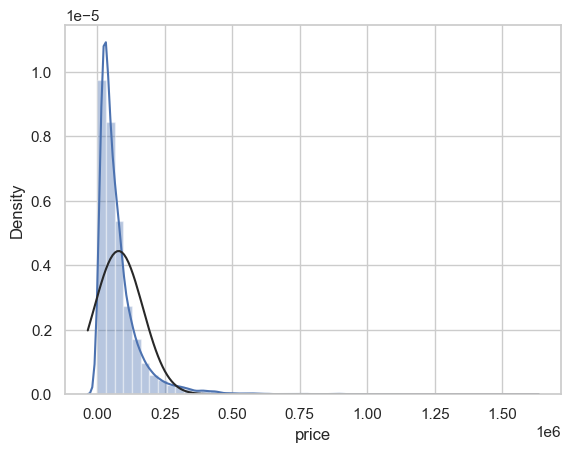

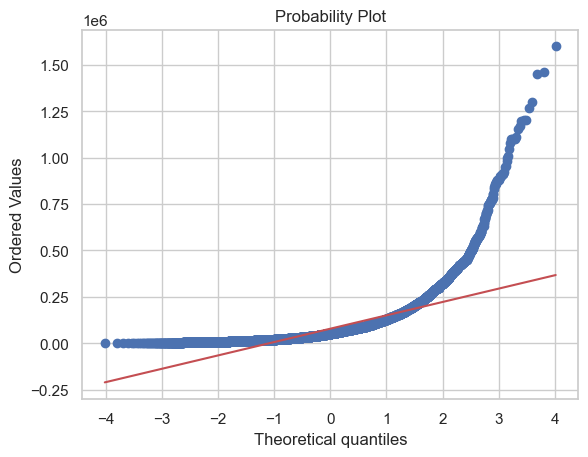

In [45]:
sns.distplot(df['price'], fit=norm)
fig = plt.figure()
res = probplot(df['price'], plot=plt)

In [46]:
skewness_value = df['price'].skew()
print(f"Skewness of Price: {skewness_value}")

Skewness of Price: 4.425938013911293


Skewness measures the asymmetry of a probability distribution. A feature can be left-skewed (negative skewness) or right-skewed (positive skewness). In this case, the feature is right-skewed. Skewed data can impact model performance, especially for models that assume a normal distribution. Ideally, we aim for skewness values within the range of -1 to 1 to ensure the data is approximately symmetric and less likely to negatively affect model performance.

Let's examine how the distribution of the *price* variable changes with different lambda values using the boxcox1p function, which is commonly used for unskewing data.

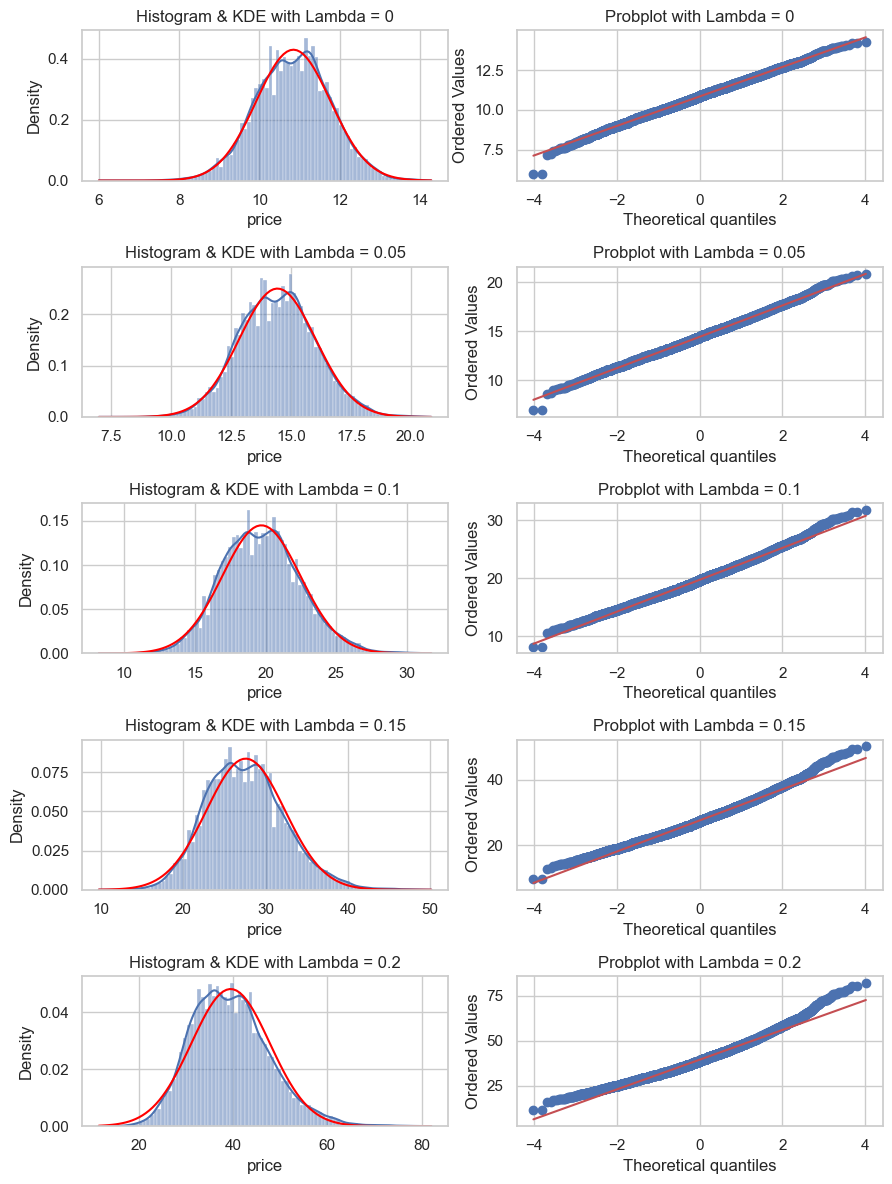

In [47]:
lambdas = [0, 0.05, 0.1, 0.15, 0.2]
fig, ax = plt.subplots(len(lambdas), 2, figsize=(9, 12))

for i, lmbda in enumerate(lambdas):
    transformed_data = boxcox1p(df['price'], lmbda)
    sns.histplot(transformed_data, ax=ax[i, 0], kde=True, stat="density")
    sns.lineplot(x=np.linspace(min(transformed_data), max(transformed_data), 100),
                 y=norm.pdf(np.linspace(min(transformed_data), max(transformed_data), 100),
                            np.mean(transformed_data), np.std(transformed_data)),
                 color="red", ax=ax[i, 0])
    ax[i, 0].set_title(f'Histogram & KDE with Lambda = {lmbda}')
    
    probplot(transformed_data, dist="norm", plot=ax[i, 1])
    ax[i, 1].set_title(f'Probplot with Lambda = {lmbda}')

plt.tight_layout()

Based on the plots, we will choose a lambda value of 0, as it appears to provide the best fit. A lambda of 0 essentially corresponds to a log transformation. That's why we can actually use log1p function instead of boxcox1p or PowerTransformer.

Note that if we were to use an adjustable lambda value, the transformation should be performed after splitting the data into training and test sets to avoid data leakage. In this case, it is not relevant.

In [48]:
df['price'] = np.log1p(df['price'])

In [49]:
df.head()

,brand,car_model,year_of_production,price,mileage,fuel_type,transmission,body,engine_capacity,power,number_of_doors,color
0,Audi,Q8,2018,12.495008,196335,Diesel,Automatic,SUV,2.967,286.0,5,Navy Blue
1,Audi,A7,2021,12.201060,93000,Plug-in Hybrid,Automatic,Coupe,1.984,265.0,5,Red
3,Audi,Q3,2024,12.164735,1,Petrol,Manual,Compact,1.498,150.0,5,Red
4,Audi,Q5,2024,12.366919,1,Diesel,Automatic,SUV,1.968,204.0,5,Blue
5,Audi,A6,2020,12.153731,98227,Diesel,Automatic,Wagon,2.967,286.0,5,Burgundy


# Model Architecture

First, let's start with dividing our dataset into features (X) and target (y).

In [50]:
X = df.drop('price', axis = 1)
y = df['price']

X.shape, y.shape

((23108, 11), (23108,))

In [51]:
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

Now, let's proceed to create a ColumnTransformer that will be used in our pipeline. This transformer will include scaling for numerical features and encoding for categorical features.

In [52]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

*StandardScaler* standardizes features by removing the mean and scaling to unit variance. It transforms the data to have a mean of 0 and a standard deviation of 1.

*OneHotEncoder* converts categorical variables into a binary (0 or 1) format by creating new columns for each category.

Now, there is an option in OneHotEncoder to drop a column, to avoid multicollinearity. For example, if you have a categorical variable "Color" with three categories (Red, Green, Blue), OHE would create three columns: Is_Red, Is_Green, and Is_Blue. But the value of one column can be concluded from the others. Right? For instance, if Is_Red and Is_Blue are both 0, Is_Green must be 1.

This raises a good question about whether to drop a column in OneHotEncoder or not.

As stated in the scikit-learn documentation:  "This is useful in situations where perfectly collinear features cause problems, such as when feeding the resulting data into an unregularized linear regression model.
However, dropping one category breaks the symmetry of the original representation and can therefore induce a bias in downstream models, for instance for penalized linear classification or regression models."

The choice of whether to drop a column when using One-Hot Encoding can have advantages or drawbacks, depending on the model used. Decision tree-based models inherently handle multicollinearity and non-linear relationships well, and since they typically yield the best results, we will not worry about this and keep all columns without dropping any. 

Now, we will set up hyperparameters for tuning each model. The models we’ll be using are:

- Ridge
- Lasso
- ElasticNet
- KNeighborsRegressor
- XGBRegressor
- LGBMRegressor
- CatBoostRegressor

In [53]:
models = [
    {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10]
        }
    },
    {
        'model': Lasso(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10]
        }
    },
    {
        'model': ElasticNet(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10],
            'model__l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    {
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    {
        'model': XGBRegressor(),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__subsample': [0.8],
            'model__colsample_bytree': [0.8],
            'model__reg_alpha': [0, 0.01, 0.1],
            'model__reg_lambda': [1, 5, 10]
        }
    },
    {
        'model': LGBMRegressor(verbose=-1),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__num_leaves': [20, 31, 50],
            'model__max_depth': [6, 9],
            'model__subsample': [0.8],
            'model__colsample_bytree': [0.8],
            'model__reg_alpha': [0, 0.01, 0.1],
            'model__reg_lambda': [1, 5, 10]
        }
    },
    {
        'model': CatBoostRegressor(verbose=0),
        'params': {
            'model__iterations': [100, 200, 300],
            'model__depth': [3, 6, 9],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__subsample': [0.8],
            'model__l2_leaf_reg': [1, 3, 5, 10]
        }
    }
]

The code below performs hyperparameter tuning for our models using cross-validation. It sets up a KFold cross-validation with five splits and shuffling to ensure a random selection of data.

For each model in the list, it creates a pipeline that includes data preprocessing (ColumnTransformer) and the model itself. A GridSearchCV is used to search for the best hyperparameters by fitting the pipeline to the input data X and target values y (RandomizedSearchCV could also be used to reduce computation time given the size of the hyperparameter space, though in this case I want it to go through all combinations). The model's performance is evaluated using negative mean squared error.

In [54]:
for entry in models:
    model = entry['model']
    params = entry['params']
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    )
    
    start_time = time.time()
    
    search.fit(X, y)

    end_time = time.time()
    
    duration = end_time - start_time
    
    print(f"Model Name: {search.best_estimator_.named_steps['model'].__class__.__name__}")
    print(f"Best score: {-search.best_score_:.4f}")
    print(f"Best params: {search.best_params_}")
    print(f"Duration: {duration:.2f} seconds")
    print("-" * 30)

Model Name: Ridge
Best score: 0.0980
Best params: {'model__alpha': 0.1}
Duration: 5.73 seconds
------------------------------
Model Name: Lasso
Best score: 0.1573
Best params: {'model__alpha': 0.01}
Duration: 4.52 seconds
------------------------------
Model Name: ElasticNet
Best score: 0.1362
Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.3}
Duration: 20.22 seconds
------------------------------
Model Name: KNeighborsRegressor
Best score: 0.0981
Best params: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Duration: 22.16 seconds
------------------------------
Model Name: XGBRegressor
Best score: 0.0665
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__reg_alpha': 0, 'model__reg_lambda': 1, 'model__subsample': 0.8}
Duration: 910.64 seconds
------------------------------
Model Name: LGBMRegressor
Best score: 0.0668
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.

NOTE: The lower the score (Mean Squared Error), the better.

Based on our analysis, the tree-based models - XGBoost, LightGBM, and CatBoost - gave us the best results. 
Let's now examine the learning curves for these models with their best hyperparameters to evaluate how well they generalize to new, unseen data and identify bias-variance issues.

In [55]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=1,
        verbosity=0
    ))
])

lgbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.1,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=1,
        verbose=-1
    ))
])

catboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(
        iterations=300,
        depth=9,
        learning_rate=0.1,
        subsample=0.8,
        l2_leaf_reg=1,
        verbose=0
    ))
])

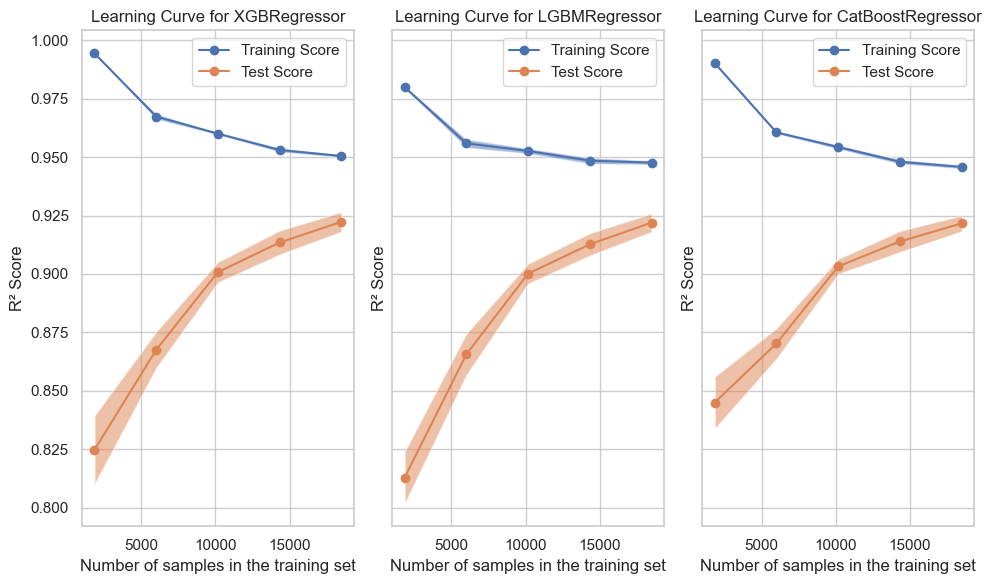

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True, sharex=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": KFold(n_splits=5, shuffle=True, random_state=42),
    "scoring": "r2",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "R² Score",
}

for ax_idx, estimator in enumerate([xgb_model, lgbm_model, catboost_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.named_steps['model'].__class__.__name__}")
plt.tight_layout()

All three models - XGBRegressor, LGBMRegressor, and CatBoostRegressor - show typical learning curve behavior: the training score decreases slightly as the training set size increases, while the test score improves significantly, indicating that the models generalize well from the training data. The gap between the training and test scores clearly narrows as more samples are used, suggesting overfitting is not a major concern. However, the gap for XGBRegressor remains marginally wider than for the other two, which could indicate a slightly higher tendency towards overfitting for that specific model in this setup. None of the models appear to suffer from underfitting, as all converge towards high test R2 scores (approximately 0.925). The test scores still show a slight upward trend at the maximum sample size presented, implying that all models could potentially benefit from even more training data. Nevertheless, the current performance results are strong and satisfying enough.

Comparing the models, there isn't a definitive winner based purely on the final R2 score. However, CatBoostRegressor appears to exhibit slightly lower variance than the other models, and the error bands are smaller, especially with larger sample sizes. Therefore, due to its marginally more stable test performance across folds, I select CatBoostRegressor as the final model.

We can now fit the model to the entire dataset, as there is no need to split the data into training and test sets or use cross-validation anymore.

In [57]:
catboost_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year_of_production',
                                                   'mileage', 'engine_capacity',
                                                   'power',
                                                   'number_of_doors']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['brand', 'car_model',
                                                   'fuel_type', 'transmission',
                                                   'body', 'color'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000001B5EECA4BF0>)])

And the model is ready to be exported and used!

Please note that the model provides predictions in a log-transformed (unskewed) format. To convert these predictions back to their original scale, we need to reverse the skewness.

Here is how to do this:

In [58]:
#predict results based on car_features
#log_price_prediction = model.predict(car_features)

#reverse the log transformation to get the predicted car price in its original scale
#price_prediction = np.expm1(log_price_prediction)

Finally, we can save our model.

In [59]:
joblib.dump(catboost_model, "car_price_model.joblib")

['car_price_model.joblib']

Due to the lengthy processing time of web scraping, some popular car models might be missing from the dataset. To avoid excessive delays, I had to make certain compromises (credit goes to my amazing computer for that 😂).

As for potential areas of improvement:
- Expanding the training set could potentially improve the model, given the upward trend in the model's test score
- Trying out additional hyperparameters that were not included in the initial tuning process may also lead to better results. With a larger hyperparameter space, consider using randomized search or Bayesian optimization